<a href="https://colab.research.google.com/github/sayan0506/Deep-Neural-Network-with-Pytorch-/blob/main/CIFAR10_CNN_model_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification using CNN using Pytorch

Here we will implement CNN based image classification technique to classify categories on CIFAR10 classification problem.

The classifiers are:

1. Airplane, 2. Automobile, 3. Bird, 4. Cat, 5. Deer, 6. Dog, 7. Frog, 8. Horse, 9. Ship, 10. Truck 

In [ ]:
# importing necessary modules
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import CIFAR10 
from torchvision.transforms import  ToTensor
from torch.utils.data.dataloader import DataLoader
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
from torch import nn
import torch.nn.functional as F

In [ ]:
# assigning a project name
project_name = 'cifar10-cnn'

In [ ]:
# download the dataset
dataset_url = "https://www.kaggle.com/c/cifar-10/data?select=train.7z"
download_url(dataset_url, '/content/Dataset')
# the datset is not available in that url
# so we will use torchvision.datasets

In [ ]:
dataset = CIFAR10(root = '/content/Dataset', train = True, download = True, transform = ToTensor())
test_dataset = CIFAR10(root = '/content/Dataset', train = False, download = True, transform = ToTensor())


Extracting /content/Dataset/cifar-10-python.tar.gz to /content/Dataset

Files already downloaded and verified


In [ ]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
dataset[0]

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

In [ ]:
# we count number of different classifiers in the dataset
class_count = {}
# index returns the label of each image in the datasets
for _, index in dataset:
  # takes the class name to assign the the class name as key to class_count dictionary
  label = classes[index]
  # if label is not in class_count, assign it as label

  if label not in class_count:
    class_count[label] = 0
  # add counters for each labeled image of that class
  class_count[label] += 1
class_count 

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

# Train and Validation split

In [ ]:
val_pct = 0.10
val_size = int(len(dataset) * val_pct)
train_size = int(len(dataset) - val_size)

In [ ]:
train_ds, validation_ds = random_split(dataset, [train_size, val_size])

In [ ]:
len(train_ds), len(validation_ds)

(45000, 5000)

In [ ]:
batch_size = 128

In [ ]:
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)
validation_dl = DataLoader(validation_ds, batch_size= batch_size, num_workers=4, pin_memory= True)
test_dataset = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)

images shape:  torch.Size([128, 3, 32, 32])


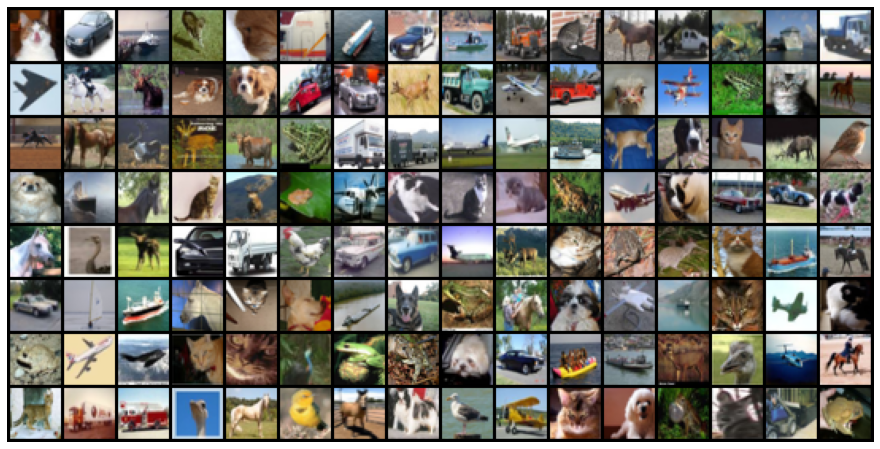

In [ ]:
for images, _ in train_dl:
  print('images shape: ', images.shape)
  plt.figure(figsize = (16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow = 16).permute((1,2,0)))
  break

In [ ]:
make_grid(images, nrow = 16).permute((1,2,0)).shape

torch.Size([274, 546, 3])

# Buiulding the CNN model

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size= 3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size= 3, stride = 1,padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size= 1, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size= 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

        nn.Flatten(), 
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10))

  def forward(self, xb):
      return self.network(xb)

  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)  
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
      print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

# Model Training

In [ ]:
?nn.Module


In [ ]:
def evaluate(model, validation_dl):
  outputs = [model.validation_step(batch) for batch in validation_dl]

def fit(epochs, lr, model, train_loader, validation_loader, opt = torch.optim.SGD):
  history = []
  optimizer = opt(model.parameters(), lr)
  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # validation phase
    #result = evaluate(model, validation_loader)
    #result['train_loss'] = torch.stack(train_losses).mean().item()
    #model.epoch_end(epoch, result)
    #history.append(result)
  return history 

# GPU utilization

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
  ## Pic GPU if available, else use the CPU
  if torch.cuda.is_available():
    return  torch.device('cuda')
  else:
    return torch.device('cpu')

# create a variable for device
device = get_default_device()
device

device(type='cuda')

In [ ]:
# move tensors to the device by checking the types of objects
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    # it ensures that whether data(or individual batches) is part of the data structures passed
    # in a recursive manner
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [ ]:
# now we create a devicefataloader for accessing dataloader with the GPU
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.device = device
    self.dl = dl

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device) 
  
  def __len__(self):
    return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_dl, device)
validation_loader = DeviceDataLoader(validation_dl, device)

# Building the CNN model


In [ ]:
class Cifa10CnnModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size= 3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size= 3, stride = 1,padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size= 1, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size= 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

        nn.Flatten(), 
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10))

    def forward(self, xb):
      return self.network(xb)

In [ ]:
model = ImageClassificationBase()
model

ImageClassificationBase(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_

In [ ]:
# sending the model to device
model = to_device(model, device)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs, lr, model, train_loader, validation_loader, opt_func)

In [ ]:
class animal():
  def __init__():
    self.f = 1

  def forward():
    print('implemented')

  def __call__(self):
    f = self.forward()
    return f

In [ ]:
img, label = test_dataset[0]

TypeError: ignored

In [ ]:
dataset.classes[label]

In [ ]:
img.shape

In [ ]:
img.permute(1,2,0).shape

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    # it contains softmax output
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
predict_image(img, model)

In [ ]:
dataset.classes[label]

In [ ]:
def predict_label(img, model):
  # convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim = 1)
  return dataset.classes[preds[0].item()]

In [ ]:
predict_image(img, model)

The shape of the image contained in the data_loader which upport the model input shape, can be found from here
https://colab.research.google.com/drive/1u3XcwmlDYZQudkmyBoqJhEf28fdwUjax#scrollTo=I5d_94SJK2BW&line=1&uniqifier=1

In [ ]:
img.unsqueeze(0).shape
# i.e four dimensional


In [ ]:
# dimension of a tensor is = (the number of features corresponding to each datapoint - 1)
# as dimension starts from 0
# a single valued tensor corresponding to a 0th dimensional tensor

In [ ]:
A = torch.tensor([[0, 1, 1], [1, 0, 1]])
B = torch.tensor([[1, 1], [1, 1], [-1, 1]])
A_times_B = torch.mm(A,B)

In [ ]:
A_times_B

In [ ]:
a=torch.tensor([[0,1,1],[1,0,1]])

In [ ]:
a.size()

In [ ]:
a.ndimension()

In [33]:
class animal(object):
  def __init__(self):
    self.x = 5
    print(self.x)

class cat(animal):
  def __init__(self):
    print('Called')

  def forward(self):
    print('Not implemented')

class human(cat):
  def __init__(self):
    super().__init__()
    print('done')

h = human()

Called
done


In [32]:
# so whenever the class is instantiated, the constructor is called